# Homework 1 : TIME SERIES

In [2]:
from fredapi import Fred
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import plotly.express as px

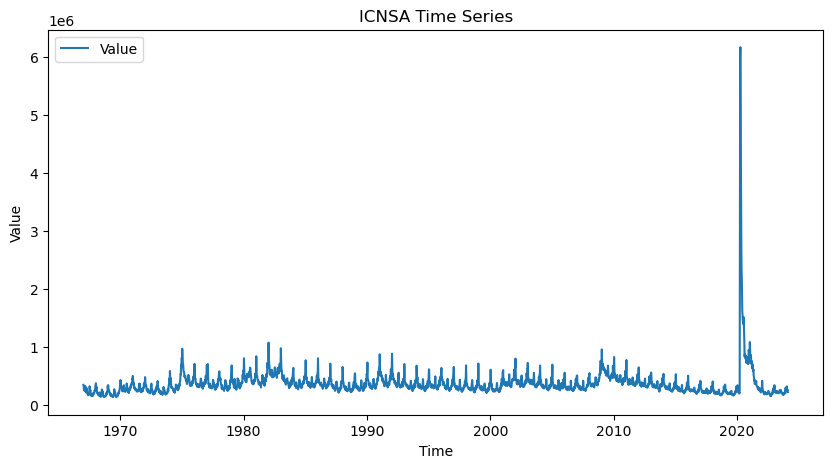

In [87]:
from fredapi import Fred
import plotly.express as px
import pandas as pd

api_key = "53b538f58efe93c97a8626e8559a0372"
fred = Fred(api_key=api_key)

series_id = "ICNSA"
data = fred.get_series(series_id)

icnsa_df = data.to_frame().reset_index()
icnsa_df.columns = ['time', 'I_value']


# Plotting the time series using Matplotlib
plt.figure(figsize=(10, 5)) 
plt.plot(icnsa_df['time'], icnsa_df['I_value'], label='Value') 
plt.title(f"{series_id} Time Series")  
plt.xlabel('Time')
plt.ylabel('Value')  
plt.legend()  
plt.show()  


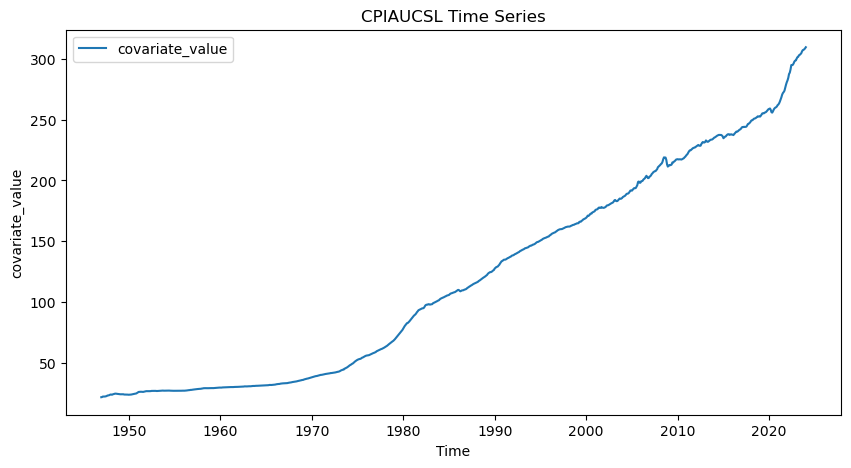

In [88]:
covariate_series_id = "CPIAUCSL"  
covariate_data = fred.get_series(covariate_series_id)
covariate_df = covariate_data.to_frame().reset_index()
covariate_df.columns = ['time', 'C_value']

# Plotting the time series using Matplotlib
plt.figure(figsize=(10, 5))  
plt.plot(covariate_df['time'], covariate_df['C_value'], label='covariate_value')  
plt.title(f"{covariate_series_id} Time Series")  
plt.xlabel('Time')  
plt.ylabel('covariate_value')  
plt.legend() 
plt.show()  


# Correlation between ICNSA and covariate: CPIAUCSL

In [89]:
correlation = icnsa_df['I_value'].corr(covariate_df['C_value'])
print(f"Correlation coefficient: {correlation}")


Correlation coefficient: 0.5882275578833972


Correlation Analysis:
The correlation coefficient of 0.588 indicates that as the CPI (Consumer Price Index) increases, there is a moderate tendency for the initial claims to increase as well, which could make CPIAUCSL a potential covariate for modeling ICNSA.

# Augmented Dickey-Fuller test for ICNSA and covariate: CPIAUCSL

In [90]:
from statsmodels.tsa.stattools import adfuller


# ICNSA
adf_result_icnsa = adfuller(icnsa_df['I_value'])
print(f"ADF Statistic for ICNSA: {adf_result_icnsa[0]}")
print(f"p-value: {adf_result_icnsa[1]}")

# CPIAUCSL
adf_result_cpi = adfuller(covariate_df['C_value'])
print(f"ADF Statistic for CPIAUCSL: {adf_result_cpi[0]}")
print(f"p-value: {adf_result_cpi[1]}")


ADF Statistic for ICNSA: -6.872346491681086
p-value: 1.5044350273818119e-09
ADF Statistic for CPIAUCSL: 2.6764245530544626
p-value: 0.9990854101445209


ADF Test Results:

For ICNSA : ADF of -6.8723 with a very small p-value, suggests that the ICNSA time series is stationary and does not require differencing to make it stationary.
For CPIAUCSL: ADF of 2.6764 with a p-value close to 1, indicating that the series is not stationary and would require differencing.

We would still need to check the PACF & ACF plots to confirm this

# Seasonal decomposition of the ICNSA series & CPIAUCSL


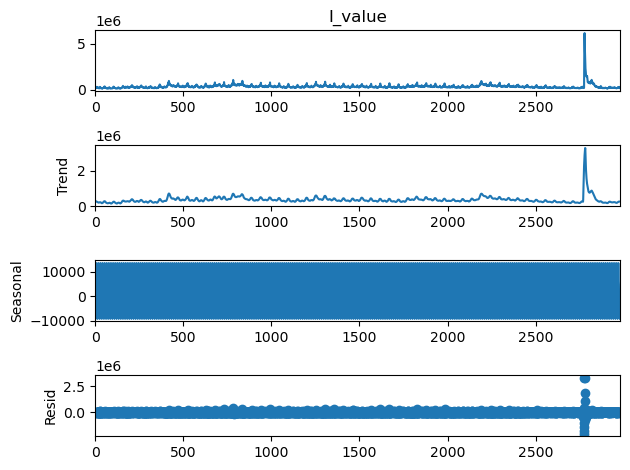

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(icnsa_df['I_value'], model='additive', period=12)
decompose_result.plot()
plt.show()




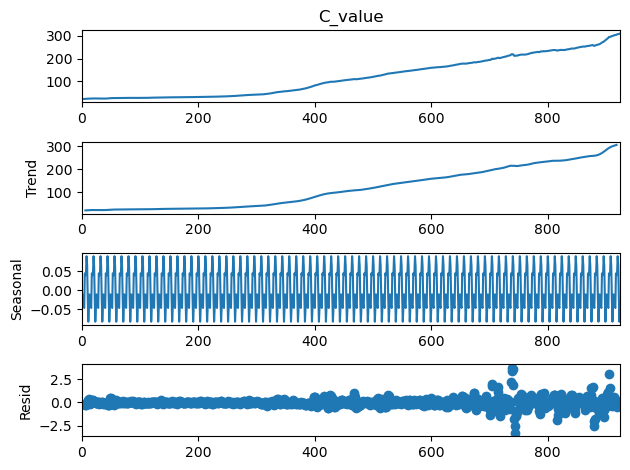

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_res = seasonal_decompose(covariate_df['C_value'], model='additive', period=12)
decompose_res.plot()
plt.show()

Seasonal Decomposition Plots:

The plot of ICNSA shows a stable seasonal pattern, as well as an increasing trend towards the end, which could be due to an outlier, such as the COVID-19 pandemic effect on employment.
The plot of CPIAUCSL shows steady upward trend, confirming non-stationarity, and some seasonal fluctuations due to consistent peaks and troughs at regular intervals 

# ACF and PACF plots for ICNSA

C:\Users\Yoda ji\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


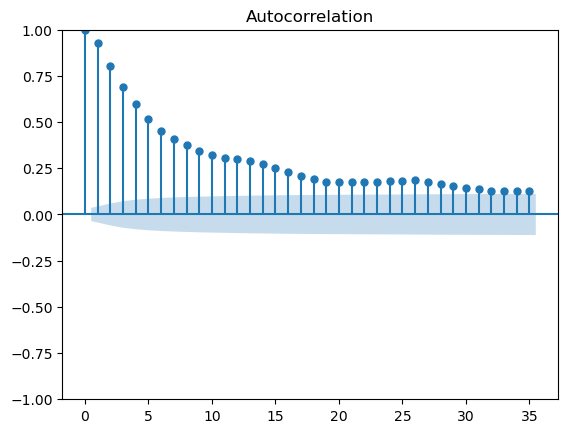

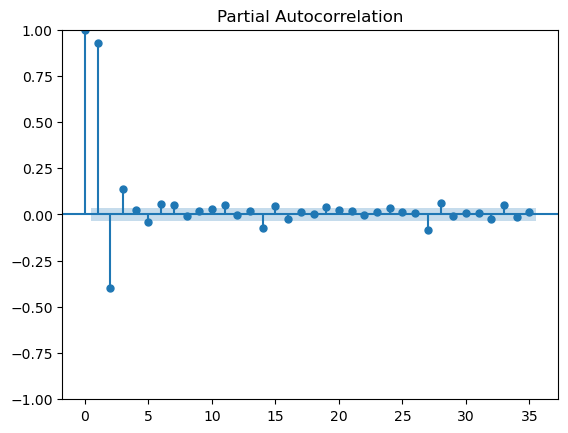

In [93]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(icnsa_df['I_value'].dropna())
plot_pacf(icnsa_df['I_value'].dropna())
plt.show()


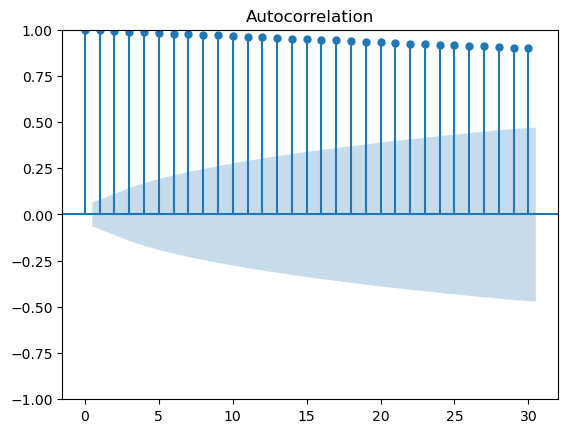

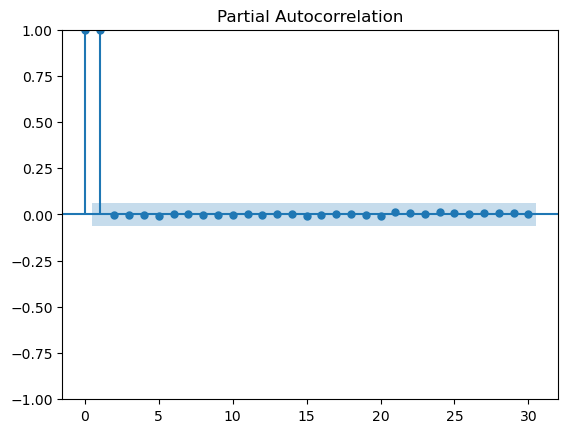

In [94]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(covariate_df['C_value'].dropna())
plot_pacf(covariate_df['C_value'].dropna())
plt.show()



ACF and PACF Plots:

The ACF plot for ICNSA shows a slow decay whereas the PACF plot for ICNSA has a significant spike at lag 1, suggesting an AR(1) component.
For CPIAUCSL, the ACF plot exhibits strong seasonal behavior with a pattern repeating every 12 lags, indicative of annual seasonality whereas the PACF plot displays a sharp drop after lag 1 indicates that there is one significant autoregressive term, which is a typical indicator of an AR(1) process.
However, since the series is non-stationary, it needs to be addressed first (by differencing the series) before the PACF can be reliably used for model identification.

In [ ]:
# Align the dates to the end of the month
monthly_icnsa['time'] = monthly_icnsa['time'] + pd.offsets.MonthEnd(0)
covariate_df['time'] = covariate_df['time'] + pd.offsets.MonthEnd(0)

#merging the DataFrames on the 'time' column
merged_df = pd.merge(monthly_icnsa, covariate_df, on='time', how='inner')

ADF Statistic: -3.9027531689323367
p-value: 0.0020146784683615524
The differenced series is stationary.


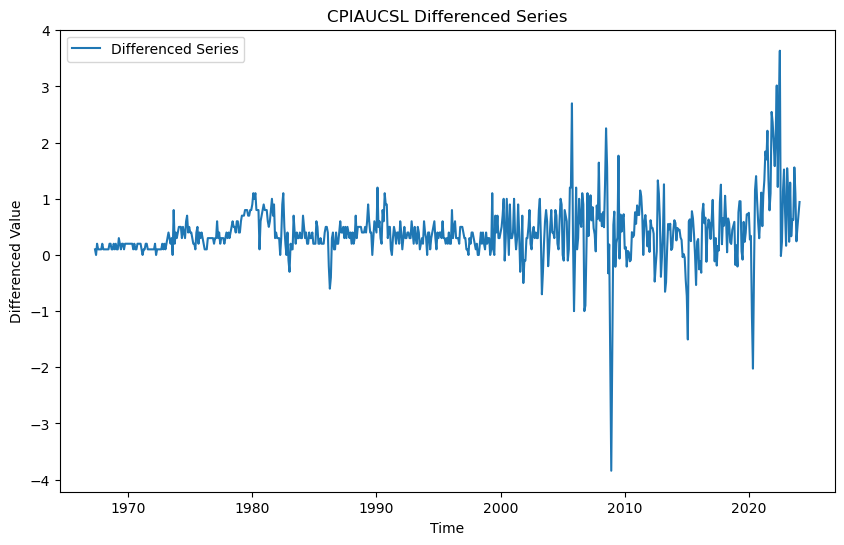

In [101]:
# Perform first-order differencing to make the series stationary
merged_df['diff_CPIAUCSL'] = merged_df['C_value'].diff().dropna()

merged_df = merged_df.dropna()

adf_result = adfuller(merged_df['diff_CPIAUCSL'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] < 0.05:
    print("The differenced series is stationary.")
else:
    print("The differenced series is not stationary.")

plt.figure(figsize=(10, 6))
plt.plot(merged_df['time'], merged_df['diff_CPIAUCSL'], label='Differenced Series')
plt.title('CPIAUCSL Differenced Series')
plt.xlabel('Time')
plt.ylabel('Differenced Value')
plt.legend()
plt.show()



C:\Users\Yoda ji\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


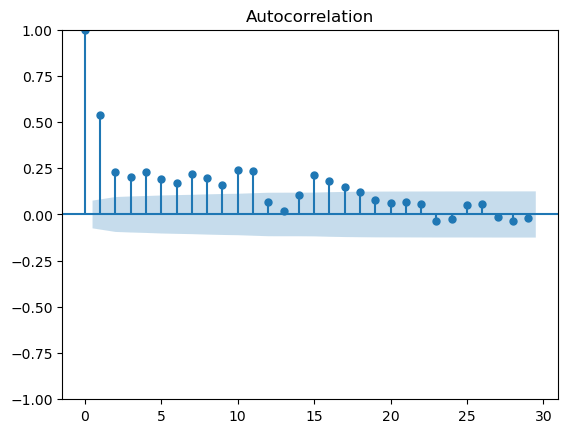

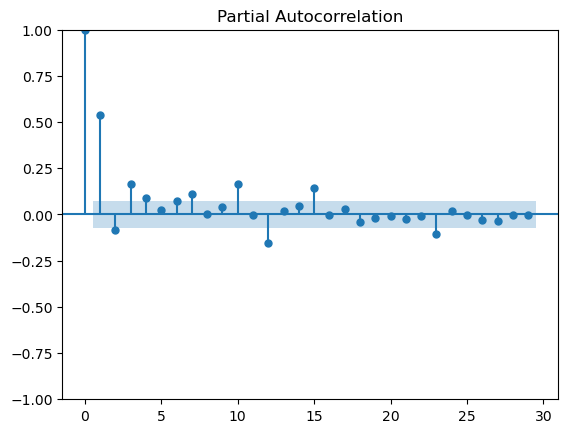

In [109]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(merged_df['diff_CPIAUCSL'].dropna())
plot_pacf(merged_df['diff_CPIAUCSL'].dropna())
plt.show()



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=18183.411, Time=2.79 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=18817.075, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=18282.574, Time=0.67 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=18383.306, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=19648.634, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=18186.331, Time=1.16 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=18184.566, Time=1.56 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=18183.000, Time=7.23 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=18181.375, Time=4.53 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=18179.964, Time=2.80 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=18182.649, Time=0.96 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=18181.863, Time=5.23 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=18183.919, Time=2.20 sec
 ARIMA(0,0,2)(2,0,0)[12] intercept   : AIC=18313.114, Time=1.71 sec
 ARIM

C:\Users\Yoda ji\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Yoda ji\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Yoda ji\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NameError: name 'future_covariate_values' is not defined

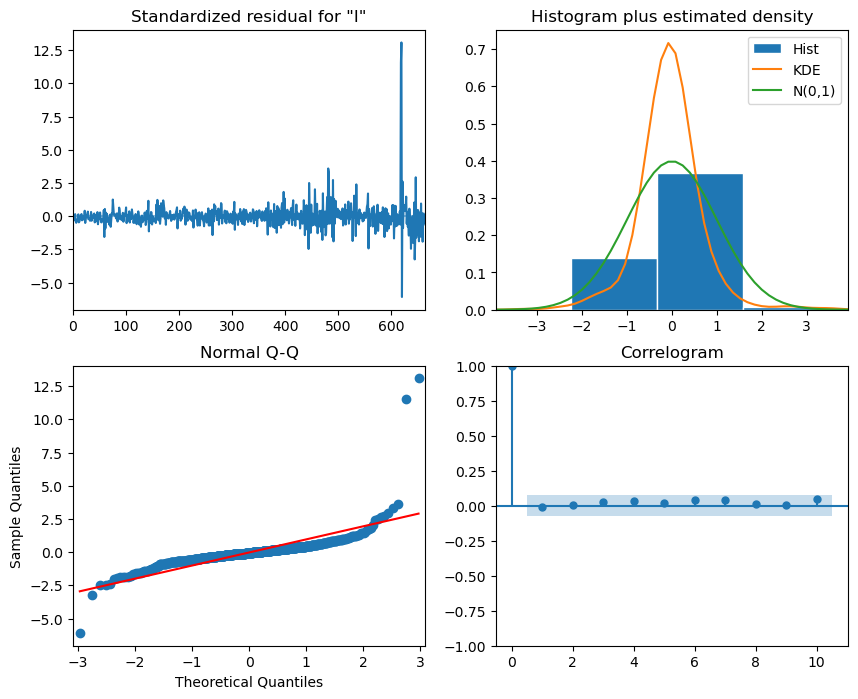

In [104]:
from pmdarima import auto_arima

auto_model = auto_arima(merged_df['I_value'], seasonal=True, m=12, trace=True, stepwise=True)


from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(merged_df['I_value'],
                exog=merged_df['diff_CPIAUCSL'],
                order=auto_model.order,
                seasonal_order=auto_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

results.plot_diagnostics(figsize=(10, 8))




In [105]:
last_known_covariate_value = merged_df['diff_CPIAUCSL'].iloc[-1]
future_covariate_values = [last_known_covariate_value] * 5  

forecast = results.get_forecast(steps=5, exog=future_covariate_values) 
forecast.summary_frame()


C:\Users\Yoda ji\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


I_value,mean,mean_se,mean_ci_lower,mean_ci_upper
682,341418.635430,221197.194576,-92119.899421,7.749572e+05
683,424793.939937,292839.086341,-149160.122557,9.987480e+05
684,457892.493104,302600.324428,-135193.244486,1.050978e+06
685,475690.738725,305856.748492,-123777.472748,1.075159e+06
686,492102.960404,307038.350368,-109681.148190,1.093887e+06


In [110]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              I_value   No. Observations:                  682
Model:             SARIMAX(5, 0, 4)x(1, 0, [1], 12)   Log Likelihood               -9117.997
Date:                              Wed, 21 Feb 2024   AIC                          18261.995
Time:                                      22:32:57   BIC                          18320.492
Sample:                                           0   HQIC                         18284.661
                                              - 682                                         
Covariance Type:                                opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
diff_CPIAUCSL  2.991e+05      0.000   6.42e+08      0.000    2.99e+05    2.99e+05
ar.L1             0.6307      3.319      0.190      0.849      -5.875       7.136
ar.L2             0.4130      3.518      0.117      0.907      -6.482       7.308
ar.L3             0.1244      1.532      0.081      0.935      -2.879       3.128
ar.L4            -0.1304      0.335     -0.389      0.697      -0.787       0.526
ar.L5            -0.0383      0.337     -0.114      0.909      -0.698       0.621
ma.L1             0.2355      3.314      0.071      0.943      -6.260       6.731
ma.L2            -0.6172      1.214     -0.508      0.611      -2.997       1.762
ma.L3            -0.4997      2.206     -0.227      0.821      -4.823       3.823
ma.L4            -0.1253      0.965     -0.130      0.897      -2.016       1.765
ar.S.L12          0.3742      1.553      0.241      0.810      -2.670       3.418
ma.S.L12         -0.3891      1.531     -0.254      0.799      -3.391       2.612
sigma2         4.886e+10   2.03e-09   2.41e+19      0.000    4.89e+10    4.89e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            165708.47
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              15.24   Skew:                             5.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        79.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+35. Standard errors may be unstable.
"""